In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rc('pdf',fonttype = 42)
plt.rc('ps',fonttype = 42)

import re

import seaborn as sns
cmap = sns.color_palette('colorblind')
# cmap

cmap = [cmap[0], cmap[1], cmap[2], cmap[4], cmap[7], cmap[8], cmap[9], cmap[5], cmap[6]]

# for c in cmap:
#     print(c)
#     print(np.array(c) / 255.0)
#     print()

In [2]:
def getAngularError(R_exp, R_est):
    return np.abs(np.arccos(min(max((np.trace(R_exp.T @ R_est) - 1.0)/2, -1.0), 1.0)))


getAngularError(np.eye(3), np.array([[1, 0, 0], [0, -1, 0], [0, 0, 1]])) / np.pi * 180

90.0

In [3]:
def filter_list(arr, thred):
    idx = np.where(np.array(arr) <= thred)
    return np.array(arr)[idx]

def filter_idx(data, rot_thred=45, trans_thred=0.5):
    idx = []
    for i in range(len(data["rot_err"])):
        if data["rot_err"][i] < rot_thred and data["trans_err"][i] < trans_thred and data["runtime"][i]>0:
            idx.append(i)
    if len(idx) == 0:
        idx = [0]
    return np.array(idx)

fls rot_err
fls trans_err


/tmp/ipykernel_148513/632438402.py:111: RuntimeWarning: divide by zero encountered in log10
  bplot = ax.boxplot([np.log10(np.array(data[nl][algo][err_type])[filter_idx(data[nl][algo])]) for nl in noise_levels_2],
/home/msun/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


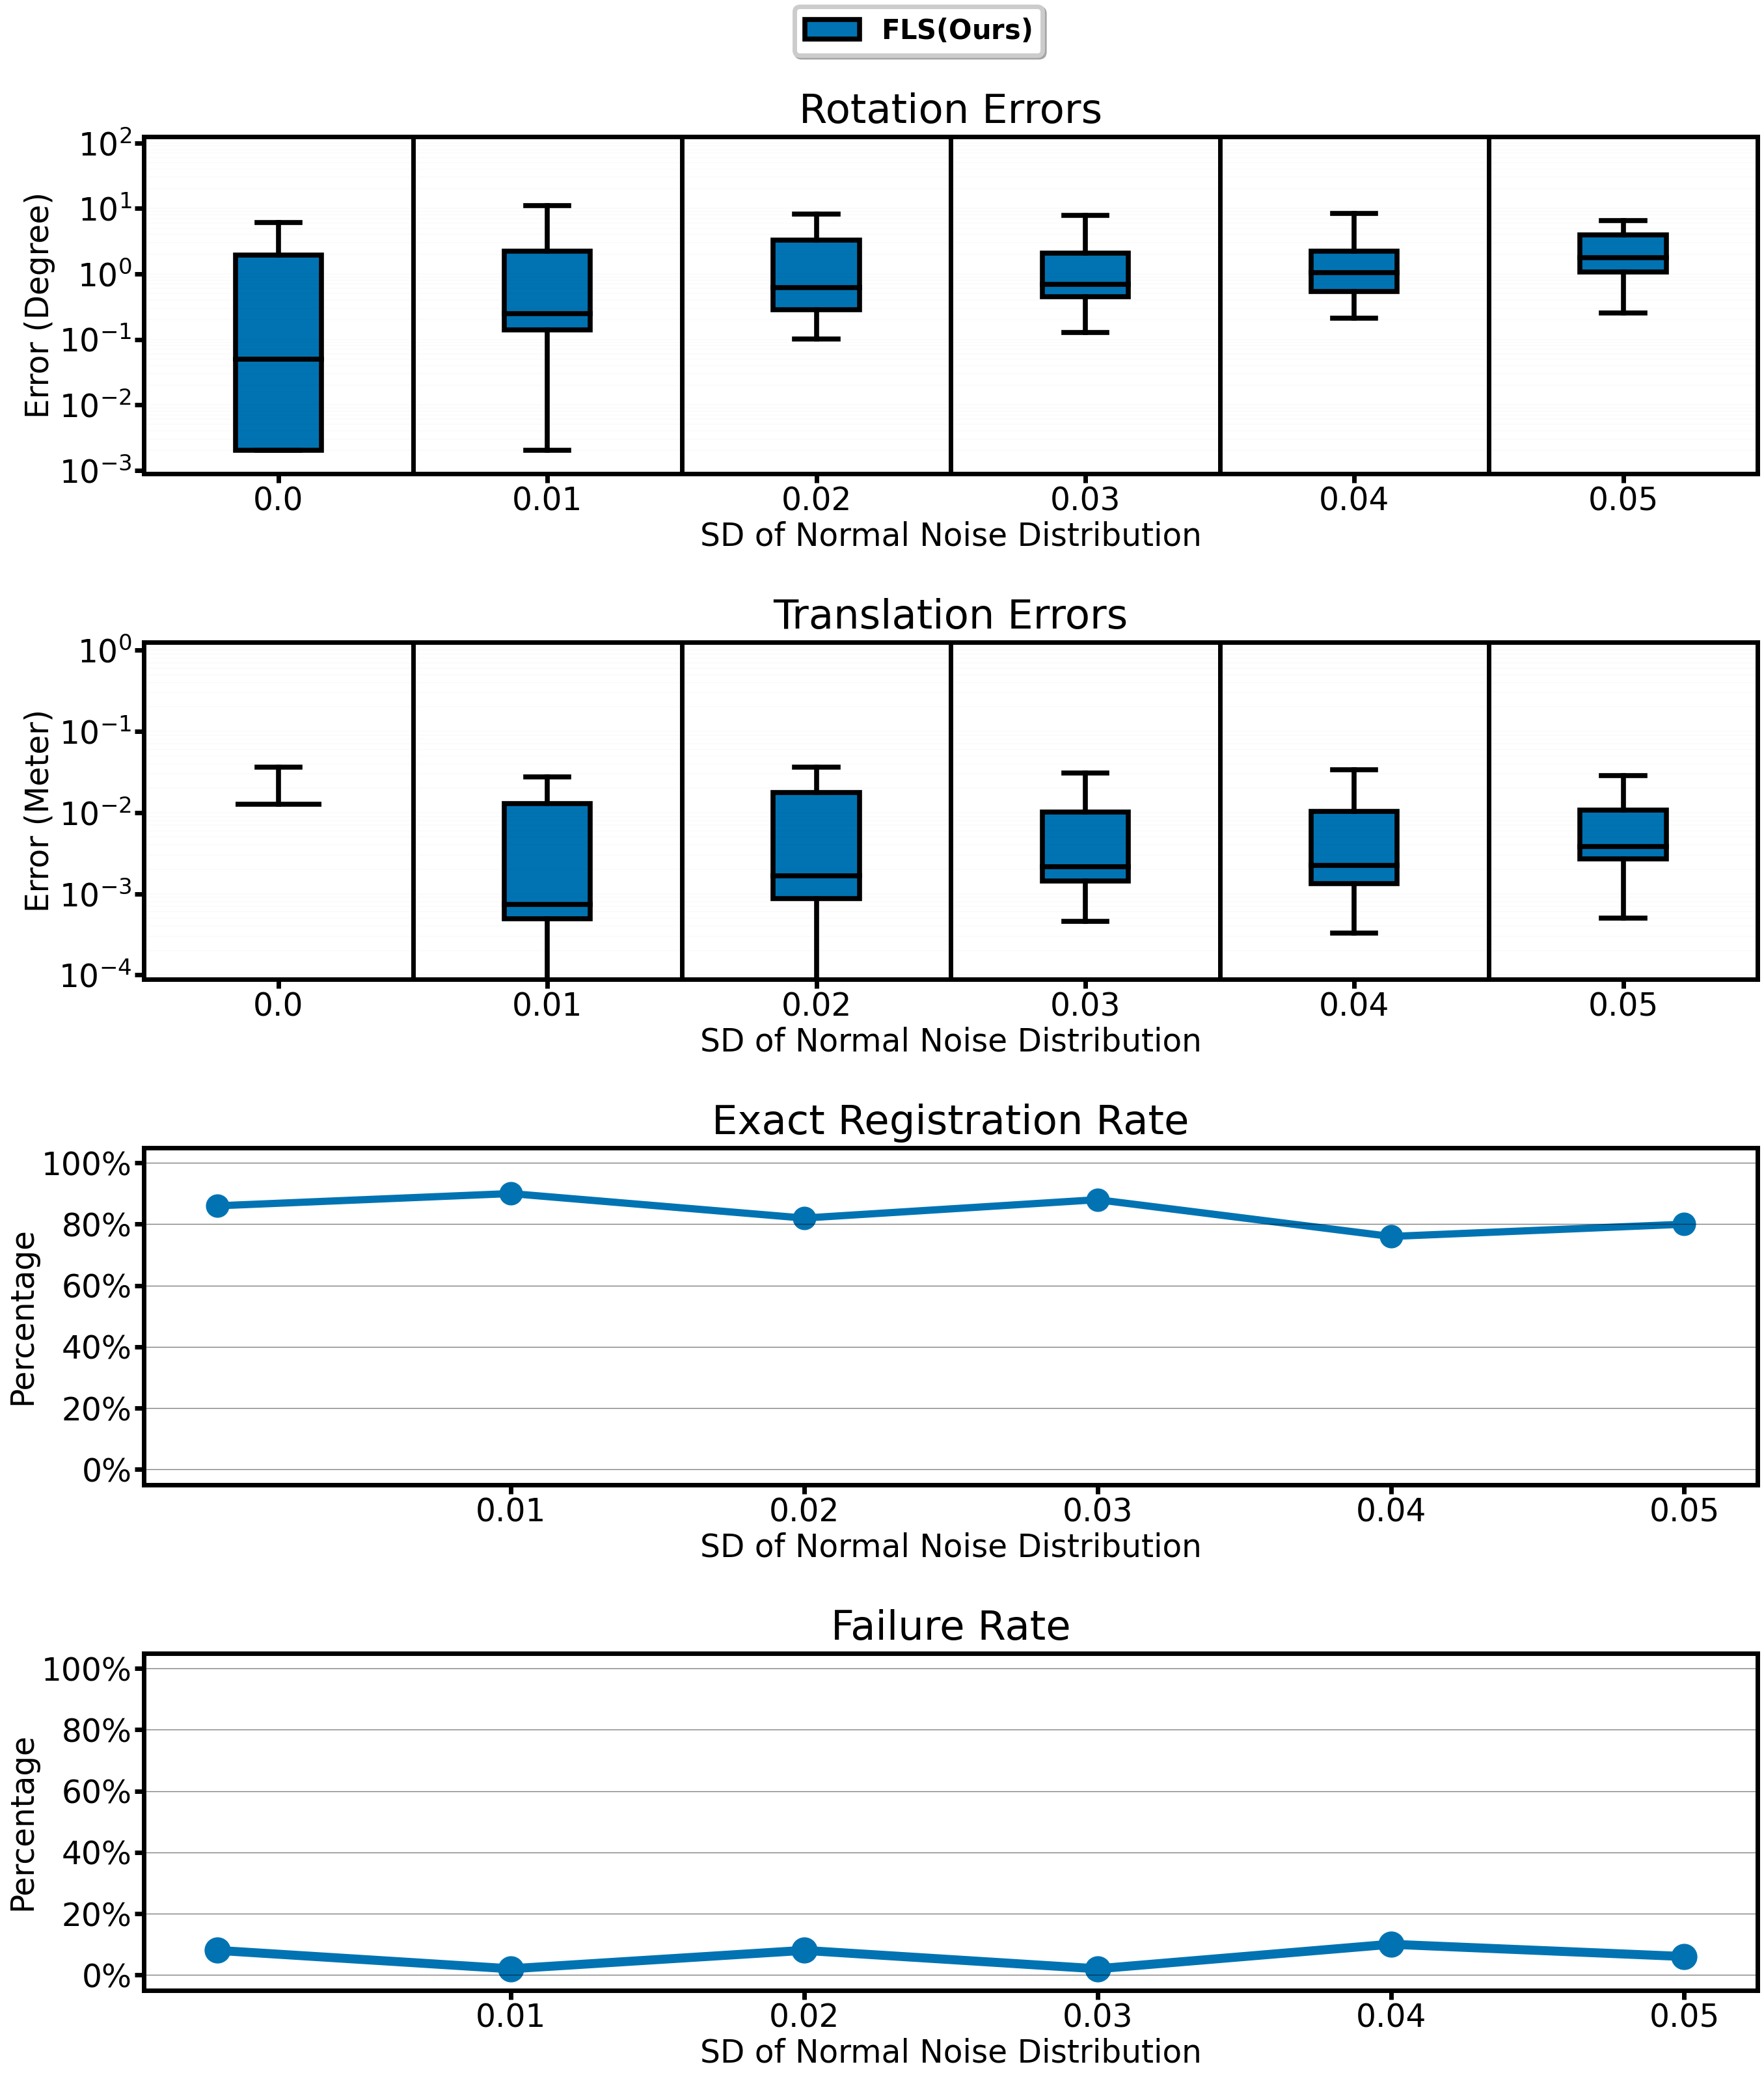

In [4]:
import os

model_names = ["airplane", "bed", "chair", "desk", "guitar", "mantel", "monitor", "piano", "sofa", "stairs"]

test_dir = "../modelnet40_noise_test/"
original_dir = "../ModelNet40_subset/"

noise_levels = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05]
noise_levels_2 = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05]
exact_recovery_rot = 5.0
exact_recovery_trans = 0.03

########################################################
algorithms = ['fls']
metrics = ['rot_err', 'trans_err', 'runtime', 'exact_recovery', 'failure']
labels = [r'$\bf{FLS(Ours)}$']

data = dict({})
for noise_level in noise_levels:
    data[noise_level] = dict({})
    for algo in algorithms:
        data[noise_level][algo] = dict({})
        for metric in metrics:
            data[noise_level][algo][metric] = []
########################################################


for model in model_names:
    file_list = os.listdir(original_dir + model + "/test/")
    object_count = 0
    for model_file in file_list:
        for noise_level in noise_levels:
            object = model_file.split('.')[0]
            filename = original_dir + model + "/test/" + object + ".off"
            # subprocess.run(["find", filename])

            # make dir for the current object
            run_dir = test_dir + object + "_" + str(noise_level) + "/"

            gt_T = np.array([float(ele) for ele in re.split(' |\n', open(run_dir + "gt_T.txt").read())[0:16]]).reshape(4,4)
            gt_R = gt_T[0:3, 0:3]
            gt_t = gt_T[0:3, 3]

            for algo in algorithms:
                if algo == 'goicp' and object_count >= 10:
                    continue
                if object_count >= 100:
                    continue
                opt_T = np.loadtxt(run_dir + algo + "_T.txt")
                opt_R = opt_T[0:3, 0:3]
                opt_t = opt_T[0:3, 3]
                runtime = np.loadtxt(run_dir + algo + "_time.txt")

                rot_err = getAngularError(gt_R, opt_R) / np.pi * 180 + 2e-03
                if np.isnan(rot_err):
                    print('nan!')
                trans_err = np.linalg.norm(gt_t - opt_t) #+ 2e-06

                exact_recovery = 0
                if rot_err < exact_recovery_rot and trans_err < exact_recovery_trans and runtime>0:
                    exact_recovery = 1

                failure = 0
                if rot_err > 45 or trans_err > 0.5 or runtime<0:
                    failure = 1

                data[noise_level][algo]['rot_err'].append(rot_err)
                data[noise_level][algo]['trans_err'].append(trans_err)
                data[noise_level][algo]['runtime'].append(runtime)
                data[noise_level][algo]['exact_recovery'].append(exact_recovery)
                data[noise_level][algo]['failure'].append(failure)

        object_count += 1

########################################################
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['axes.linewidth'] = 5.0 #set the value globally

plt.rc('pdf',fonttype = 42)
plt.rc('ps',fonttype = 42)

offset1 = 1.0 / len(noise_levels_2)

fig, axes = plt.subplots(4, 1, figsize=(32, 37), tight_layout=False)

for ax_id in range(2):
    ax = axes[ax_id]
    err_type = metrics[ax_id]
    
    box_plots = []
    for a in range(len(algorithms)):
        if a == 0 or a == 1:
            boxprops = dict(color="black",linewidth=5.5)
            medianprops = dict(color="black",linewidth=5.5)
            whiskerprops = dict(color="black", linewidth=5.5)
            capprops = dict(color="black", linewidth=5.5)
            outlier_sym = ''
        else:
            boxprops = dict(color="black",linewidth=3.5)
            medianprops = dict(color="black",linewidth=3.5)
            whiskerprops = dict(color="black", linewidth=3.5)
            capprops = dict(color="black", linewidth=3.5)
            outlier_sym = ''
        
        algo = algorithms[a]
        offset2 = offset1 / (len(algorithms)+1.5)

        print(algo, err_type)
        bplot = ax.boxplot([np.log10(np.array(data[nl][algo][err_type])[filter_idx(data[nl][algo])]) for nl in noise_levels_2], 
                            sym=outlier_sym, 
                            positions=[i*offset1 + offset2*1.25 + a*offset2 for i in range(0,len(noise_levels_2))], widths=[offset2*0.8 for _ in noise_levels_2],
                            autorange=True,
                            patch_artist=True,
                            whis = (0, 100),
                            boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops)

        for box in bplot['boxes']:
            box.set(facecolor=cmap[a])

        box_plots.append(bplot) 

    log_levels = 10
    log_start = 1000.0
    for ll in range(log_levels):
        for val in np.arange(log_start, log_start*10, log_start):
            ax.axhline(np.log10(val), xmin=0, xmax=1, color='k', linewidth=0.1, alpha=0.2)
        log_start *= 0.1


    for i in range(1, len(noise_levels_2)):
        ax.axvline(offset1 * i, ymin=0, ymax=1, color='k', linewidth=5)
    ax.set_xlim(0.0, 1.0)
    
    if ax_id == 0:
        ax.set_title("Rotation Errors", fontsize=45, pad=15)
        ax.set_xlabel("SD of Normal Noise Distribution", fontsize=35)
        ax.set_ylabel("Error (Degree)", fontsize=35)
    if ax_id == 1:
        ax.set_title("Translation Errors", fontsize=45, pad=15)
        ax.set_xlabel("SD of Normal Noise Distribution", fontsize=35)
        ax.set_ylabel("Error (Meter)", fontsize=35)

    ax.xaxis.set_tick_params(width=5, size=10)
    ax.yaxis.set_tick_params(width=5, size=10)
    
    plt.sca(axes[ax_id])
    plt.xticks([offset1/2 + offset1*i for i in range(0, len(noise_levels_2))], ['{:.2}'.format(nl) for nl in noise_levels_2], 
               fontsize=35)
    
    if ax_id == 0:
        plt.yticks([-i for i in range(-7, 7)], [r'$10^{%s}$' % -i for i in range(-7, 7)], fontsize=35)
        ax.set_ylim(-3.05, 2.1)
    if ax_id == 1:
        plt.yticks([-i for i in range(-7, 7)], [r'$10^{%s}$' % -i for i in range(-7, 7)], fontsize=35)
        ax.set_ylim(-4.05, 0.1)

# plot exact_recovery rate
ax = axes[2]
xlist = np.array(noise_levels_2)

for i in range(len(algorithms)):
    algo = algorithms[i]
    ylist = []
    for noise_level in noise_levels_2:
        exact_recovery_rate = np.mean(data[noise_level][algo]['exact_recovery']) * 100
        ylist.append(exact_recovery_rate)
    ax.plot(xlist, ylist, color=cmap[i], linewidth=8, marker='o', markersize=25)

plt.sca(axes[2])
plt.xticks([0.01 * i for i in range(1, 6)], [str(0.01 * i) for i in range(1, 6)],fontsize=35)
plt.yticks([i for i in range(0, 120, 20)], [r'{}%'.format(i) for i in range(0, 120, 20)], fontsize=35)
ax.set_ylim(-5, 105)
for i in range(0, 120, 20):
    ax.axhline(i, xmin=0, xmax=1, color='k', linewidth=1.0, alpha=0.5)

ax.set_title("Exact Registration Rate", fontsize=45, pad=15)
ax.set_xlabel("SD of Normal Noise Distribution", fontsize=35)
ax.set_ylabel("Percentage", fontsize=35)

ax.xaxis.set_tick_params(width=5, size=10)
ax.yaxis.set_tick_params(width=5, size=10)

# plot failure rate
ax = axes[3]
xlist = np.array(noise_levels_2)

for i in range(len(algorithms)):
    algo = algorithms[i]
    ylist = []
    for noise_level in noise_levels_2:
        failure_rate = np.mean(data[noise_level][algo]['failure']) * 100
        ylist.append(failure_rate)
    if i == 0:
        ax.plot(xlist, ylist, color=cmap[i], linewidth=10, marker='o', markersize=28)
    elif i == 1:
        ax.plot(xlist, ylist, color=cmap[i], linewidth=7, marker='o', markersize=23)
    else:
        ax.plot(xlist, ylist, color=cmap[i], linewidth=8, marker='o', markersize=25)

plt.sca(axes[3])
plt.xticks([0.01 * i for i in range(1, 6)], [str(0.01 * i) for i in range(1, 6)],fontsize=35)
plt.yticks([i for i in range(0, 120, 20)], [r'{}%'.format(i) for i in range(0, 120, 20)], fontsize=35)
ax.set_ylim(-5, 105)
for i in range(0, 120, 20):
    ax.axhline(i, xmin=0, xmax=1, color='k', linewidth=1.0, alpha=0.5)

ax.set_title("Failure Rate", fontsize=45, pad=15)
ax.set_xlabel("SD of Normal Noise Distribution", fontsize=35)
ax.set_ylabel("Percentage", fontsize=35)

ax.xaxis.set_tick_params(width=5, size=10)
ax.yaxis.set_tick_params(width=5, size=10)

# configure legend
lgd = plt.legend([bp["boxes"][0] for bp in box_plots], 
          [label for label in labels], fontsize=30,
          loc='lower center', bbox_to_anchor=(0.48, +5.7),
          ncol=len(algorithms)-1, fancybox=True, shadow=True)  
lgd.get_frame().set_linewidth(5.0)

plt.subplots_adjust(hspace=0.5)
plt.show()
plt.close()
########################################################


In [5]:
ns = 0.00
for algo in algorithms:
    print("\n================== {} ==================".format(algo))
    for metric in metrics:
        if metric == 'rot_err' or metric == 'trans_err':
            metric_mean = np.mean(np.array(data[ns][algo][metric])[filter_idx(data[ns][algo])])
            metric_std = np.std(np.array(data[ns][algo][metric])[filter_idx(data[ns][algo])])
        elif metric == 'runtime':
            metric_mean = np.mean(np.array(data[ns][algo][metric])[np.where(np.array(data[ns][algo][metric])>0)])
            metric_std = np.std(np.array(data[ns][algo][metric])[np.where(np.array(data[ns][algo][metric])>0)])
        else:
            metric_mean = failure_rate = np.mean(data[ns][algo][metric]) * 100
            metric_std = 0.0
        print("{}: {}+-{}".format(metric, metric_mean, metric_std))


================== fls ==================
rot_err: 1.0316139990174105+-1.5757061535914592
trans_err: 0.006332204446654357+-0.010082357594920833
runtime: 0.07491798+-0.04436503952415235
exact_recovery: 86.0+-0.0
failure: 8.0+-0.0
